# Prediction Report

In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import warnings

from datetime import date
from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    classification_report,
    matthews_corrcoef,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    accuracy_score,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

warnings.filterwarnings("ignore")
%matplotlib inline

## Pre-process Data

In [2]:
### TRAINING SETS ###
df_all = pd.read_csv("../data/target1_cleaned.csv")

### EMBEDDINGS ###
with open("../embeddings/specter_embeddings_target1.json", "r") as fp:
    specter_json = json.load(fp)
specter_embed = [i["embedding"] for i in specter_json]

In [3]:
# Create training data splits
p_group = df_all["Project"]

train_idx = p_group[p_group.isin(["t1"])].index
test_idx = p_group[p_group.isin(["Pilots"])].index

In [4]:
sns.set(rc={"figure.figsize": (11.7, 8.27)}, font_scale=1.5)

def train_then_predict(
    clf, X, y, train_idx, test_idx, multi=False, cv=5, cv_predict=False
):
    
    if multi == True:
        clf = OneVsRestClassifier(clf)

    if cv_predict == True:
        y_pred = cross_val_predict(clf, X.loc[train_idx], y.loc[train_idx], cv=cv)
        y_probs = cross_val_predict(clf, X.loc[train_idx], y.loc[train_idx], cv=cv, method="predict_proba")
        
        if isinstance(y, pd.Series):
            y_pred = pd.Series(y_pred, index=train_idx).loc[test_idx]
            y_probs = pd.DataFrame(y_probs, index=train_idx).loc[test_idx]
        else:
            y_pred = pd.DataFrame(y_pred, index=train_idx, columns=y.columns).loc[test_idx]
            y_probs = pd.DataFrame(y_probs, index=train_idx, columns=y.columns).loc[test_idx]
        
        y_pred = np.array(y_pred)
        y_probs = np.array(y_probs)
    else:
        clf_fit = clf.fit(X.loc[train_idx], y.loc[train_idx])
        y_pred = clf_fit.predict(X.loc[test_idx])
        y_probs = clf_fit.predict_proba(X.loc[test_idx])

    return y_pred, y_probs

def plot_cm_sns(cm, question, labels):

    cmap = plt.get_cmap("Blues")

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt="g", ax=ax, cmap=cmap)

    # labels, title and ticks
    ax.set_xlabel("Model labels")
    ax.set_ylabel("Human labels")
    ax.set_title(f"Confusion Matrix: {question}")
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.yticks(rotation=0)

    plt.show()

def cm_mc_fp_fn(cm):

    fp = 0
    fn = 0

    for nr, row in enumerate(cm):
        for nc, cell in enumerate(row):
            if nr < nc:
                fp += cell
            elif nr > nc:
                fn += cell
            elif nr == nc:
                continue

    return (fp, fn)


def create_cm_dict(fp, fn, question, category, reviewer_disagree_type="False Positive"):

    num_fp_sampled = int(fp * 0.5)
    num_fn_sampled = int(fn * 0.8)
    question_disagree = fp + fn

    cm_dict = {}
    cm_dict["Question"] = question
    cm_dict["Category"] = category
    cm_dict["Disagree_Type"] = reviewer_disagree_type
    cm_dict["Question_Disagree"] = question_disagree

    if (
        reviewer_disagree_type == "False Positive"
        or reviewer_disagree_type == "Below Diagonal"
    ):
        cm_dict["Disagreements"] = fp
        cm_dict["Num_Sampled"] = num_fp_sampled
        cm_dict["%_of_Question_Disagree"] = "{0:.1%}".format(
            num_fp_sampled / question_disagree
        )
        cm_dict["%_of_Answer_Disagree"] = "{0:.1%}".format(num_fp_sampled / fp)
    elif (
        reviewer_disagree_type == "False Negative"
        or reviewer_disagree_type == "Above Diagonal"
    ):
        cm_dict["Disagreements"] = fn
        cm_dict["Num_Sampled"] = num_fn_sampled
        cm_dict["%_of_Question_Disagree"] = "{0:.1%}".format(
            num_fn_sampled / question_disagree
        )
        cm_dict["%_of_Answer_Disagree"] = "{0:.1%}".format(num_fn_sampled / fn)
    else:
        raise ValueError("reviewer_disagree_type unknown.")

    return cm_dict


def prediction_report(df, preds, labels, question, multi=False):

    cm_list = []

    if multi == False:
        cm = confusion_matrix(df, preds, labels=labels)
        print(classification_report(df, preds, labels=labels))
        print()
        plot_cm_sns(cm, question, labels)
        fp, fn = cm_mc_fp_fn(cm)
        for rdt in ["Below Diagonal", "Above Diagonal"]:
            cm_dict = create_cm_dict(fp, fn, question, question, rdt)
            cm_list.append(cm_dict)

    else:
        cm = multilabel_confusion_matrix(df, preds)
        for i, j in enumerate(df):
            print(j)
            print()
            print(classification_report(df[j], preds[:, i]))
            plot_cm_sns(cm[i], j, labels)
            print()
            print()

            tn, fp, fn, tp = cm[i].ravel()
            for rdt in ["False Positive", "False Negative"]:
                cm_dict = create_cm_dict(fp, fn, question, j, rdt)
                cm_list.append(cm_dict)

    return cm_list

# Critical Field Prediction

| Critical Field | Type |
|----------------|------|
|Human	| Species |
|Other Mammal |	Species |
|Exogenous Chemical Exposure | Chemical |
|In Vivo | Study Type |
|In Vitro | Study Type |
|Human Clinical or Descriptive | Study Type |
|TH Serum Distributor | MIE |
|Membrane Transport Proteins | MIE |

In [5]:
lr = LogisticRegression(max_iter=2000, random_state=42)
X = pd.DataFrame(specter_embed)

# Critical Field Labels
chem_labels = ["Yes_Chemical", "No_Chemical"]
study_type_cols = [
    "In_Vitro",
    "In_Vivo",
    "Clinical_Descriptive",
]
mie_cols = [
    "Serum_ THBP",
    "Mem_Transporters",
]
species_cols = [
    "Human",
    "Other_Mammal",
]

# Chemical, Study Type
preds_chem, probs_chem = train_then_predict(
    lr, X, df_all["Chemical"], train_idx, test_idx
)
preds_study, probs_study = train_then_predict(
    lr, X, df_all[study_type_cols], train_idx, test_idx, multi=True
)

# MIEs, Species
preds_mie, probs_mie = train_then_predict(
        lr, X, df_all[mie_cols], train_idx, test_idx, multi=True
)
preds_species, probs_species = train_then_predict(
        lr, X, df_all[species_cols], train_idx, test_idx, multi=True
)

# Model Evaluation

## Chemical Exposure

              precision    recall  f1-score   support

Yes_Chemical       0.92      0.84      0.88        83
 No_Chemical       0.63      0.77      0.70        31

   micro avg       0.82      0.82      0.82       114
   macro avg       0.78      0.81      0.79       114
weighted avg       0.84      0.82      0.83       114




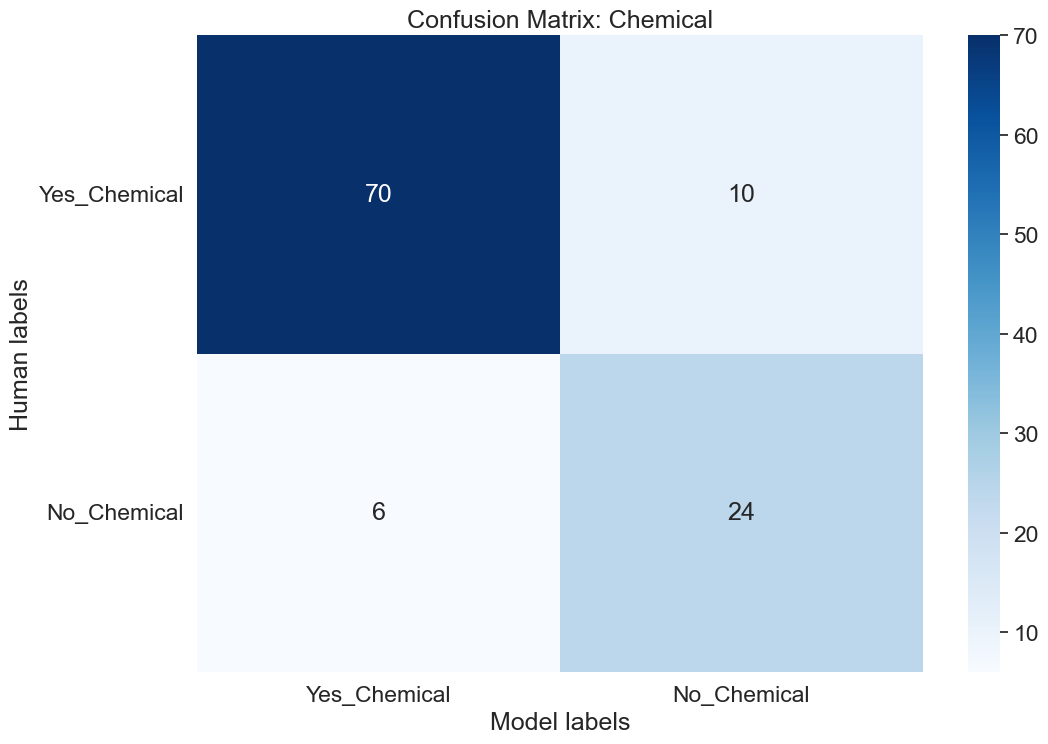

In [6]:
chem_cm_list = prediction_report(df_all.iloc[test_idx]["Chemical"], preds_chem, chem_labels, "Chemical")

## Study Type
- In Vitro
- In Vivo
- Clinical or Descriptive

In_Vitro

              precision    recall  f1-score   support

           0       0.74      0.93      0.83        59
           1       0.91      0.68      0.78        59

    accuracy                           0.81       118
   macro avg       0.83      0.81      0.80       118
weighted avg       0.83      0.81      0.80       118



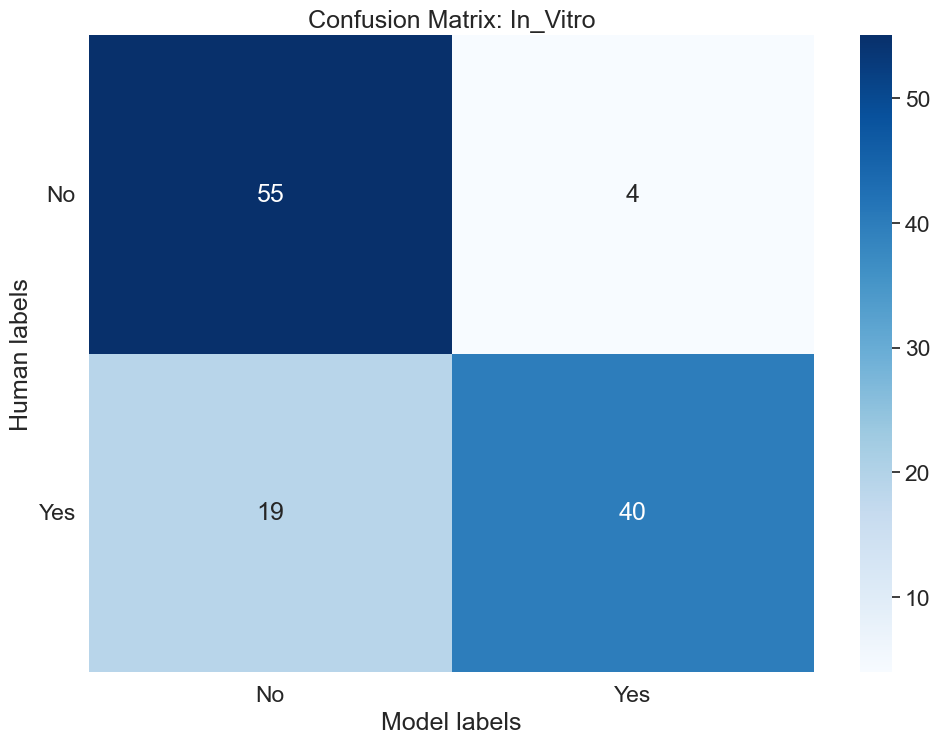



In_Vivo

              precision    recall  f1-score   support

           0       0.88      0.54      0.67        69
           1       0.58      0.90      0.70        49

    accuracy                           0.69       118
   macro avg       0.73      0.72      0.69       118
weighted avg       0.76      0.69      0.68       118



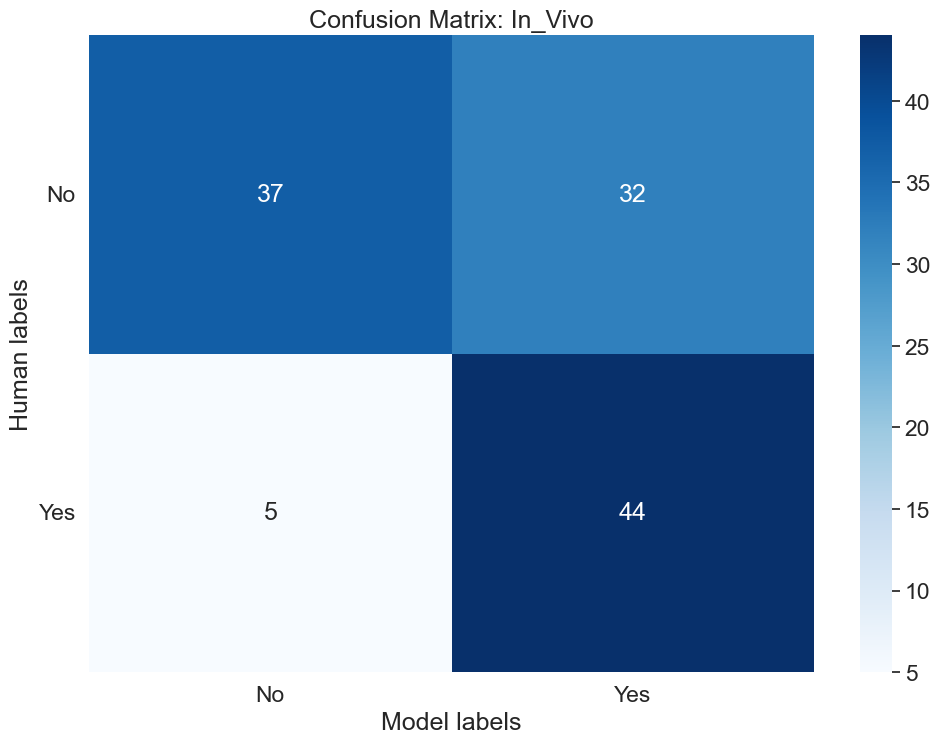



Clinical_Descriptive

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       109
           1       0.36      0.44      0.40         9

    accuracy                           0.90       118
   macro avg       0.66      0.69      0.67       118
weighted avg       0.91      0.90      0.90       118



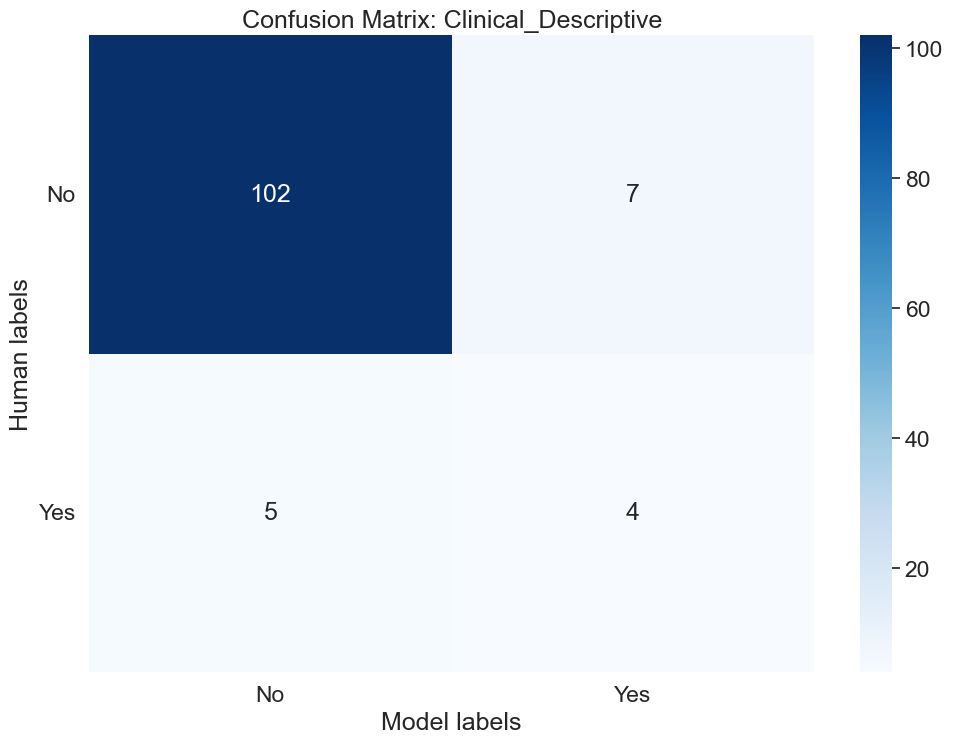

In [7]:
study_cm_list = prediction_report(
    df_all.iloc[test_idx][study_type_cols], preds_study, ["No", "Yes"], "Study Type", multi=True
)

## MIEs
- TH Serum Distributor
- Membrane Transport Proteins

Serum_ THBP

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       108
           1       0.32      0.60      0.41        10

    accuracy                           0.86       118
   macro avg       0.64      0.74      0.67       118
weighted avg       0.91      0.86      0.88       118



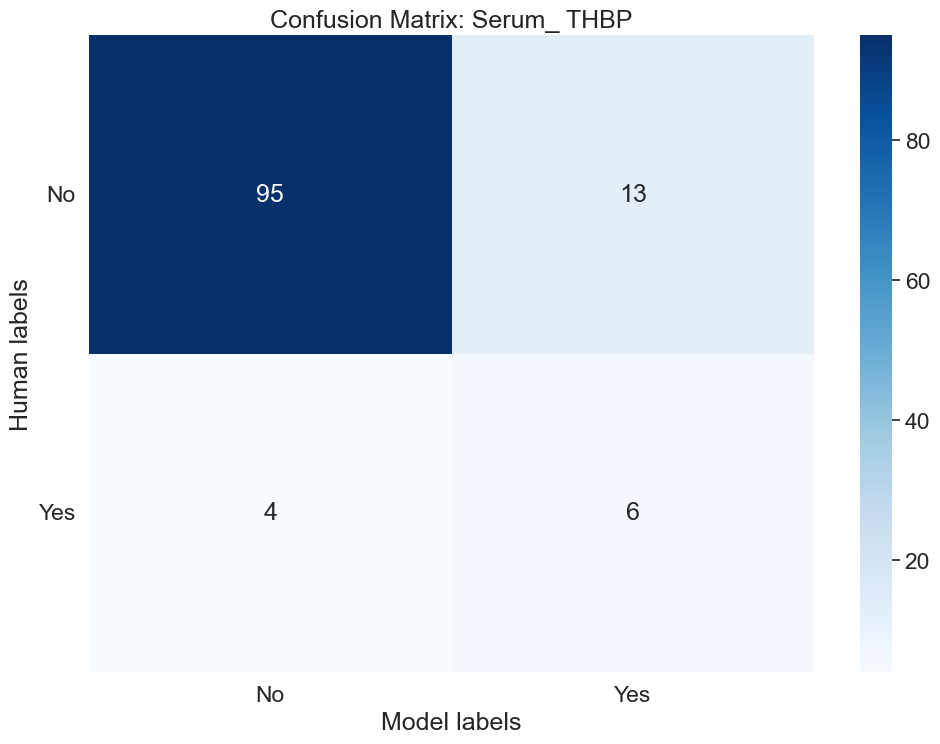



Mem_Transporters

              precision    recall  f1-score   support

           0       0.96      0.87      0.91        99
           1       0.54      0.79      0.64        19

    accuracy                           0.86       118
   macro avg       0.75      0.83      0.77       118
weighted avg       0.89      0.86      0.87       118



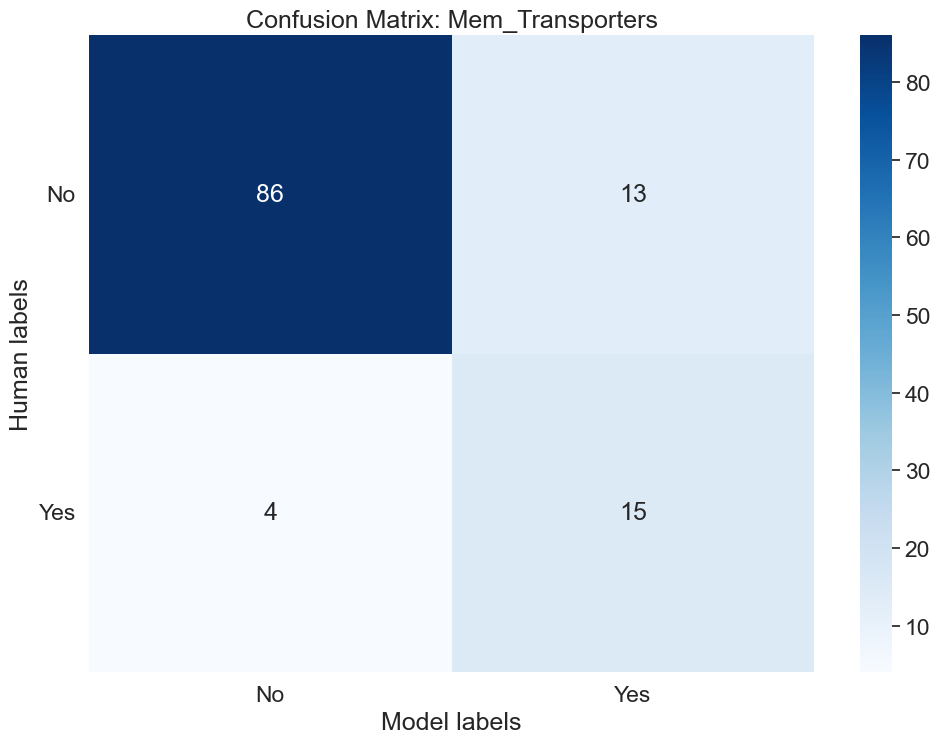

In [8]:
mie_cm_list = prediction_report(df_all.iloc[test_idx][mie_cols], preds_mie, ["No", "Yes"], "MIEs", multi=True)

## Species 
- Human
- Other Mammal

Human

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        75
           1       0.81      0.58      0.68        43

    accuracy                           0.80       118
   macro avg       0.80      0.75      0.76       118
weighted avg       0.80      0.80      0.79       118



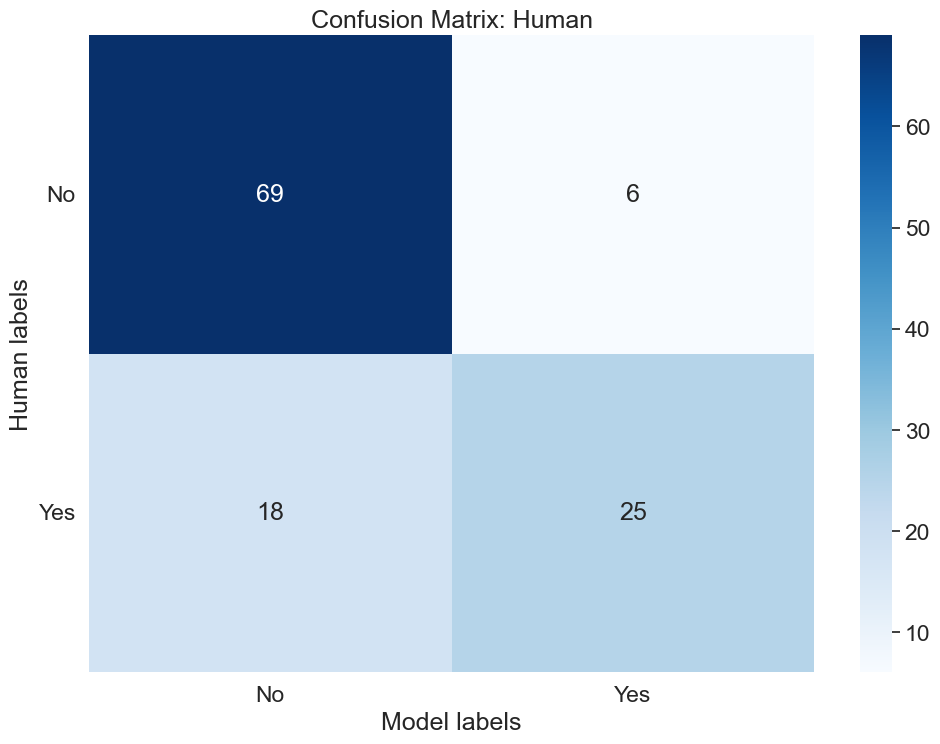



Other_Mammal

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       103
           1       1.00      0.07      0.12        15

    accuracy                           0.88       118
   macro avg       0.94      0.53      0.53       118
weighted avg       0.90      0.88      0.83       118



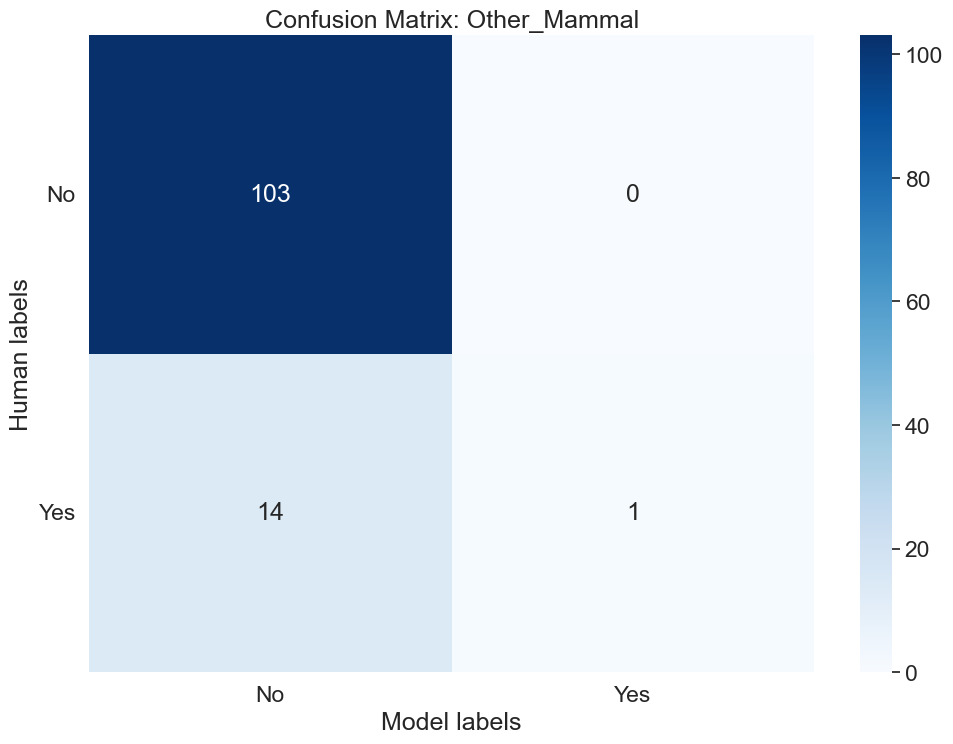

In [9]:
species_cm_list = prediction_report(df_all.iloc[test_idx][species_cols], preds_species, ["No", "Yes"], "Species", multi=True)